In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from kernels import K_classical, K_simple_RX, K_phi_RX, K_layered, K_L_tower, K_L_prod, K_L_cheb
import pennylane as qml
from optim import multivalued_mmr_DE, mmr_DE


In [2]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer.noise import NoiseModel

backend = GenericBackendV2(num_qubits=8)
noise_model = NoiseModel.from_backend(backend)

In [3]:
kernels = {
    'RBF': K_classical(0.20),
    '2L-prod': K_L_prod(N=8, n_layers=2),
    '2L-tower': K_L_tower(N=8, n_layers=2),
    '2L-cheb' :K_L_cheb(N=8, n_layers=2),
    '1L-prod': K_L_prod(N=8, n_layers=1),
    '1L-tower': K_L_tower(N=8, n_layers=1),
    '1L-cheb' :K_L_cheb(N=8, n_layers=1),
    'K_XYZ': K_layered(N=8, n_layers=3),
}

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/leonardeyer/Documents/Notes/Uni/Applied Quantum Algorithms/Project/QKM/venv/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in arccos
  return f_raw(*args, **kwargs)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

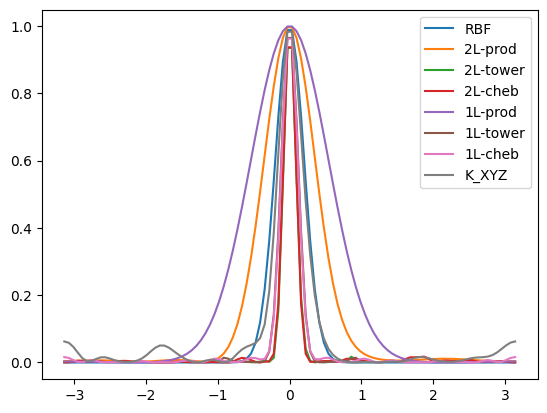

In [3]:
# compare the kernels
xs = np.linspace(-np.pi, np.pi, 100)

for label, kernel in kernels.items():
    plt.plot(xs, [kernel(x, 0) for x in tqdm(xs)], label=label)

plt.legend()
plt.show()

In [4]:
def make_DE(llambda, kk):
    def df_dx(x, f, l, k):
        return -l * k * f -l * np.exp(-l * k * x) * np.sin(l * x)
    
    def DE(x, f, dfdx):
        return dfdx - df_dx(x, f, llambda, kk)
    
    def f_sol(x):
        return np.exp(-llambda * kk * x) * np.cos(llambda * x)
    
    return DE, f_sol

In [8]:
llambda = 20
kk = 0.1

DE, sol = make_DE(llambda, kk)

x = np.linspace(0, 1, 21)
y = x
results = {}

In [10]:
for label, kernel in tqdm(kernels.items()):
    print(f'Running {label}')
    f_sol, losses = mmr_DE(DE=DE, data=[x, y], x0=0.0, f0=1.0, k=kernel)

    results[label] = (x, [f_sol(x) for x in x], losses)

  0%|          | 0/8 [00:00<?, ?it/s]

Running RBF
Loss:  622.7072809337178
Loss:  56.241028340680494
Loss:  0.9590673977580654
Optimization terminated successfully.
         Current function value: 0.148385
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 1450
         Hessian evaluations: 0
Running 2L-prod
Loss:  797.4081735404093
Loss:  499.61864795193594
Loss:  410.9745804363969
Loss:  378.2349236499165


/Users/leonardeyer/Documents/Notes/Uni/Applied Quantum Algorithms/Project/QKM/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2104: OptimizeWarning: Warning: CG iterations didn't converge. The Hessian is not positive definite.
  return terminate(3, msg)


         Current function value: 378.234858
         Iterations: 23
         Function evaluations: 45
         Gradient evaluations: 2409
         Hessian evaluations: 0
Running 2L-tower
Loss:  7.529080568449636
Loss:  0.5698620807125951
Loss:  0.15126877977154068
Loss:  0.004354749236458036
         Current function value: 0.004355
         Iterations: 20
         Function evaluations: 27
         Gradient evaluations: 3152
         Hessian evaluations: 0
Running 2L-cheb


/Users/leonardeyer/Documents/Notes/Uni/Applied Quantum Algorithms/Project/QKM/venv/lib/python3.10/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/leonardeyer/Documents/Notes/Uni/Applied Quantum Algorithms/Project/QKM/venv/lib/python3.10/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in add
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/leonardeyer/Documents/Notes/Uni/Applied Quantum Algorithms/Project/QKM/venv/lib/python3.10/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


         Current function value: nan
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 880
         Hessian evaluations: 0
Running 1L-prod
Loss:  871.5501040439864
Loss:  797.0380106684263
Optimization terminated successfully.
         Current function value: 797.030117
         Iterations: 13
         Function evaluations: 18
         Gradient evaluations: 343
         Hessian evaluations: 0
Running 1L-tower
Loss:  10.049134688607829
Loss:  0.22496305672229938
         Current function value: 0.000454
         Iterations: 14
         Function evaluations: 22
         Gradient evaluations: 1913
         Hessian evaluations: 0
Running 1L-cheb
         Current function value: nan
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 880
         Hessian evaluations: 0
Running K_XYZ
Loss:  176.30958829054853
Loss:  1.9049584443863319
         Current function value: 0.423289
         Iterations: 12
         Function eva

In [19]:
results.keys()

dict_keys(['RBF', '2L-prod', '2L-tower', '2L-cheb', '1L-prod', '1L-tower', '1L-cheb', 'K_XYZ'])

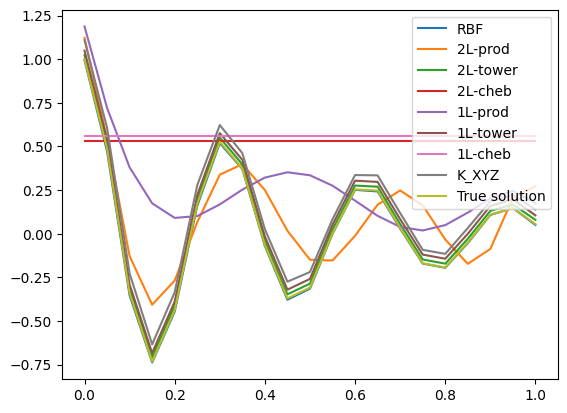

In [15]:
for i, (label, (x, result, losses)) in enumerate(results.items()):
    plt.plot(x, np.array(result) + i * 0.01, label=label)
    
plt.plot(x, sol(x), label='True solution')
plt.legend()
plt.savefig('data/mmr_linear_DE_results.png')

In [34]:
"""
 params = {
    "training_data": (x_train, y_train),
    "optimized": {
        "MMR RBF": (x, mmr_classical_predict),
        "MMR QK": (x, mmr_quantum_predict),
    },
    "errors": {
        "MMR RBF": (x, mmr_classical_predict - y),
        "MMR QK": (x, mmr_quantum_predict - y)
    },
    "losses": {
        "MMR RBF": losses_classical,
        "MMR QK": losses_quantum
    }
}
"""

params = {
    "training_data": (x, sol(x)),
    "optimized": {},
    "errors": {},
    "losses": {}
}

for i, (label, (x, result, losses)) in enumerate(results.items()):
    params["optimized"][label] = (x, result)
    params["errors"][label] = (x, result - sol(x))
    params["losses"][label] = losses

In [35]:
import pickle

pickle.dump(params, open('data/mmr_linear_DE_results.pkl', 'wb'))

dict_keys(['training_data', 'optimized', 'errors', 'losses'])


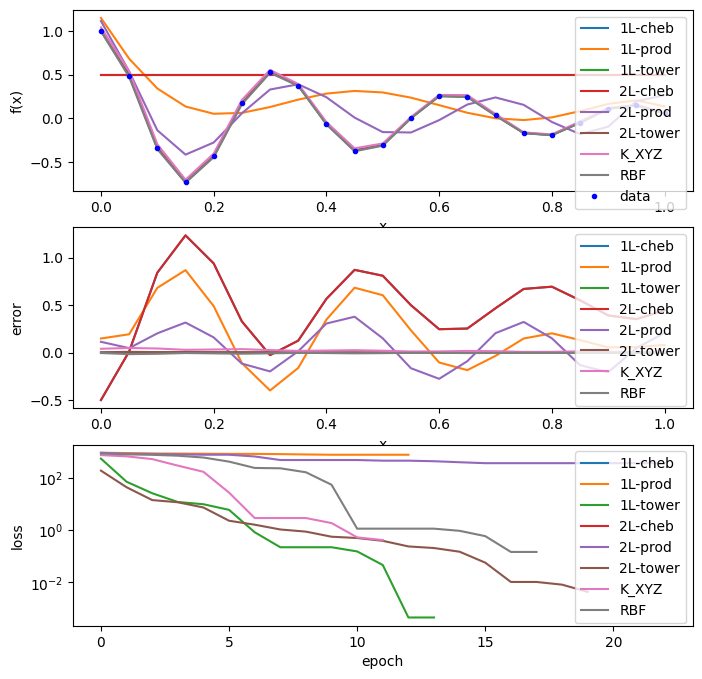

In [1]:
import pickle
from util import plot_mmr_results

params = pickle.load(open('data/mmr_linear_DE_results.pkl', 'rb'))

print(params.keys())

plot_mmr_results(**params, save=True, label='linear_DE')

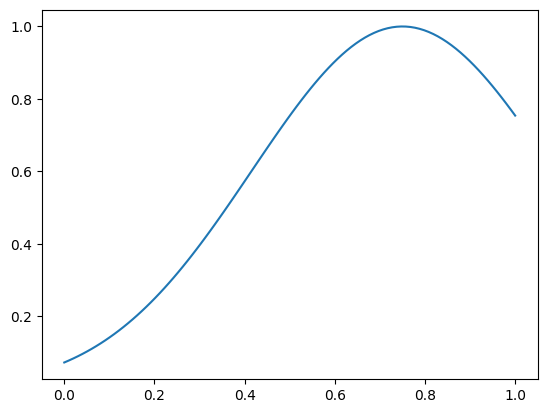

In [19]:
k = kernels["2L-prod"]
xs = np.linspace(0, 1, 100)
plt.plot(xs, [k(0.75, x) for x in xs])

In [20]:
f_sol = mmr_DE(DE=DE, data=[x, y], x0=0.0, f0=1.0, k=k)

Loss:  945.3999119199493
Loss:  872.8384542494202
Loss:  852.3660647821431
Loss:  818.4324420799512
Loss:  793.5910153660454
Loss:  793.1367906437989
Loss:  537.0336178323575
Loss:  362.0310094982797
Loss:  362.03100817168786
Optimization terminated successfully.
         Current function value: 362.031008
         Iterations: 9
         Function evaluations: 14
         Gradient evaluations: 181
         Hessian evaluations: 0


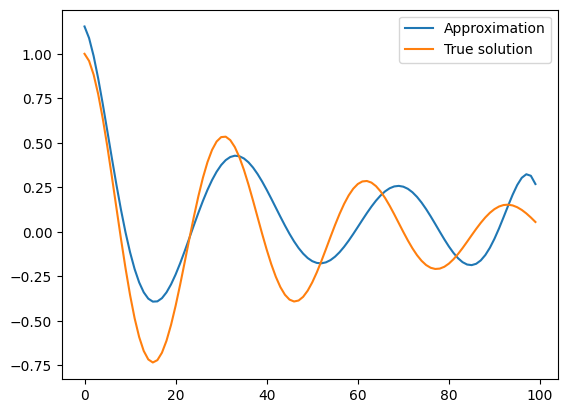

In [22]:
xs = np.linspace(0, 1, 100)
plt.plot([f_sol(x) for x in xs], label='Approximation')
plt.plot([sol(x) for x in xs], label='True solution')
plt.legend()
plt.show()